In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense,LeakyReLU,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve


In [ ]:
d = pd.read_csv('/content/drive/MyDrive/FDS/creditcard.csv')

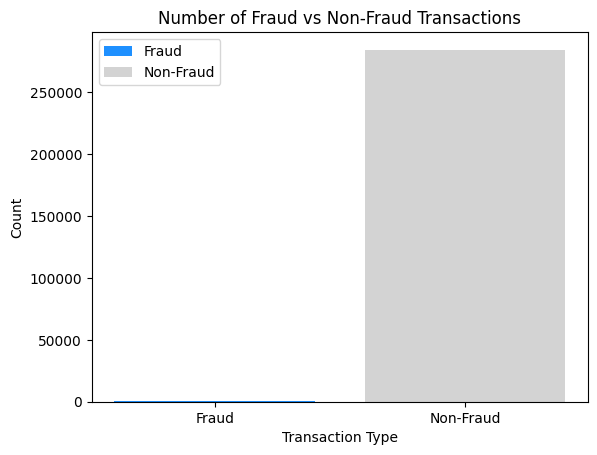

In [ ]:
num_nonfraud = np.sum(d['Class'] == 0)
num_fraud = np.sum(d['Class'] == 1)

fraud_label = 'Fraud'
nonfraud_label = 'Non-Fraud'

fraud_count = [num_fraud]
nonfraud_count = [num_nonfraud]

plt.bar(fraud_label, fraud_count, color='dodgerblue', label='Fraud')
plt.bar(nonfraud_label, nonfraud_count, color='lightgrey', label='Non-Fraud')

plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Number of Fraud vs Non-Fraud Transactions')

plt.legend()
plt.show()

In [ ]:
data = d.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data[['Amount']])
X = data.drop(['Class'],axis=1)
Y = data.Class


In [ ]:
input_dim = X.shape[1]
encoding_dim = 128
num_epoch = 30
batch_size = 256

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim,
                activation="tanh",
                activity_regularizer=regularizers.l1(10e-5)
                )(input_layer)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU(alpha=0.2)(encoder)

encoder = Dense(int(encoding_dim/2),
                activation="relu"
                )(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU(alpha=0.1)(encoder)

encoder = Dense(int(encoding_dim/4),
                activation="relu"
                )(encoder)
encoder = BatchNormalization()(encoder)

decoder = LeakyReLU(alpha=0.1)(encoder)
decoder = Dense(int(encoding_dim/4),
                activation='tanh'
                )(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU(alpha=0.1)(decoder)

decoder = Dense(int(encoding_dim/2),
                activation='tanh'
                )(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU(alpha=0.1)(decoder)

decoder = Dense(input_dim,
                # activation='relu'
                )(decoder)

autoencoder = Model(inputs=input_layer,
                    outputs=decoder
                    )

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['mae','mse']
                    )


In [ ]:
checkpointer = ModelCheckpoint(filepath="autoencoder_model.h5",
                               verbose=0,
                               save_best_only=True
                               )


In [ ]:
history = autoencoder.fit(X,
                          X,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          #validation_data=(X_test, X_test),
                          verbose=1,
                          callbacks=[checkpointer]
                          ).history


Epoch 1/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 1.1296 - mae: 0.4776 - mse: 0.5973
Epoch 2/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3091 - mae: 0.2805 - mse: 0.2252
Epoch 3/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2284 - mae: 0.2331 - mse: 0.1634
Epoch 4/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2038 - mae: 0.2044 - mse: 0.1327
Epoch 5/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1747 - mae: 0.1817 - mse: 0.1141
Epoch 6/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1465 - mae: 0.1663 - mse: 0.0931
Epoch 7/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1394 - mae: 0.1556 - mse: 0.0838
Epoch 8/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1549 - mae: 0.1535 - mse: 0.0883
Epoch 9/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1149 - mae: 0.1391 - mse: 0.0685
Epoch 10/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1184 - mae: 0.1344 - mse: 0.0641
Epoch 11/30
1113/1113 ━━━━━━

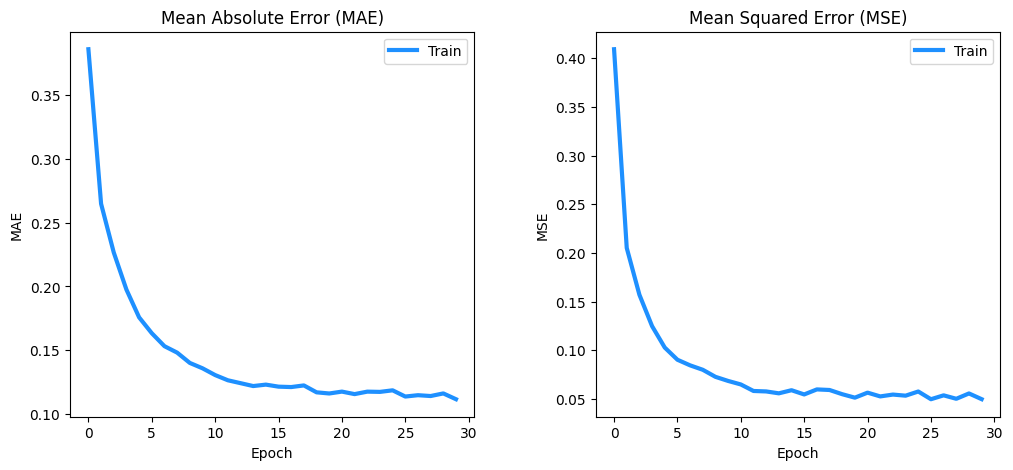

In [ ]:
# MAE 그래프
plt.subplot(121)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

# MSE 그래프
plt.subplot(122)
plt.plot(history['mse'], c='dodgerblue', lw=3)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

plt.subplots_adjust(wspace=0.3)
plt.gcf().set_size_inches(12, 5)

plt.show()


In [ ]:
pred_X = autoencoder.predict(X)

mse_X = np.mean(np.power(X - pred_X, 2), axis=1)
mae_X = np.mean(np.abs(X - pred_X), axis=1)

data['mse_X'] = mse_X
data['mae_X'] = mae_X

n = 1000
df = data.sort_values(by='mae_X', ascending=False)
top_n_df = df.head(n)
accuracy = top_n_df[top_n_df['Class'] == 1].shape[0] / n
print('Top-{} 정확도: {}'.format(n, accuracy))


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
Top-1000 정확도: 0.225


2671/2671 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


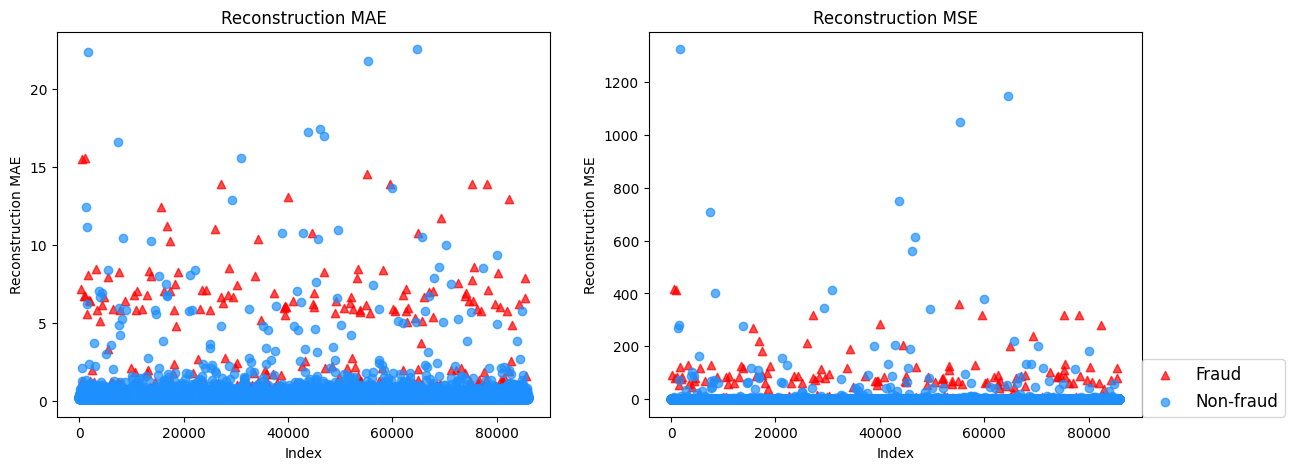

In [ ]:
mask = (data['Class'] == 0)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=520)

X_fraud = X[~mask]


pred_test  = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)

mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)
mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)


markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'red']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index,
                temp['MAE'],
                alpha=0.7,
                marker=markers[flag],
                c=colors[flag],
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE')
plt.xlabel('Index')

plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index,
                temp['MSE'],
                alpha=0.7,
                marker=markers[flag],
                c=colors[flag],
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12)
plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE')
plt.xlabel('Index')
plt.show()
